In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 2: Load Dataset
df = pd.read_csv("enhanced_synthetic_discount_dataset.csv")

In [ ]:
# Step 3: Derive frequency features BEFORE dropping IDs
df['user_activity_count'] = df['user_pseudo_id'].map(df['user_pseudo_id'].value_counts())
df['item_popularity'] = df['item_id'].map(df['item_id'].value_counts())

In [ ]:
# Step 4: Drop Unused Columns
df.drop(columns=[
    'user_pseudo_id', 'item_id', 'item_name', 'event_name',
    'discounted_price', 'event_date', 'region', 'city', 'country'
], inplace=True)

In [ ]:
# Step 5: Drop NA rows for SMOTE compatibility
df = df[df['converted'].isin([0, 1])].copy()

In [ ]:
# Step 6: Define Features and Target
target = 'converted'
features = [
    'original_price', 'discount_percent', 'item_category', 'campaign_type', 'channel',
    'hour_of_day', 'day_of_week', 'days_since_first_event',
    'user_product_view_count', 'user_product_purchase_count',
    'user_product_interaction_count', 'user_activity_count', 'item_popularity'
]

In [ ]:
X = df[features]
y = df[target]

In [ ]:
# Step 7: Identify Column Types
categorical_cols = ['item_category', 'campaign_type', 'channel', 'day_of_week']
numerical_cols = [col for col in features if col not in categorical_cols]

In [ ]:
# Step 8: Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [ ]:
# Step 9: Model Definitions
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=(y == 0).sum() / (y == 1).sum(), random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

In [ ]:
# Step 10: Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


🔍 Training Random Forest...
📊 Classification Report for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9198
           1       0.99      1.00      0.99       802

    accuracy                           1.00     10000
   macro avg       0.99      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

🧮 Confusion Matrix for Random Forest


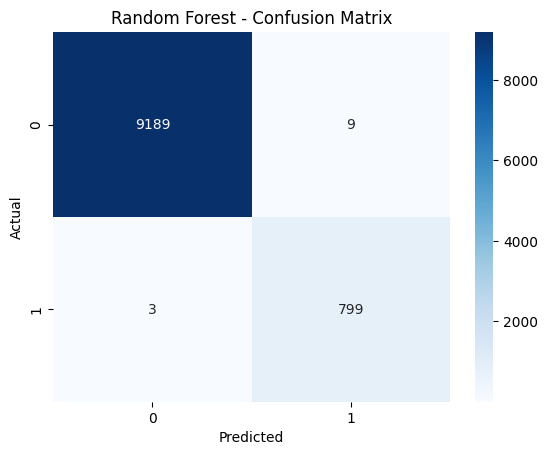

🔢 ROC-AUC Score: 1.0000

🔍 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:21:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9198
           1       0.99      1.00      0.99       802

    accuracy                           1.00     10000
   macro avg       0.99      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

🧮 Confusion Matrix for XGBoost


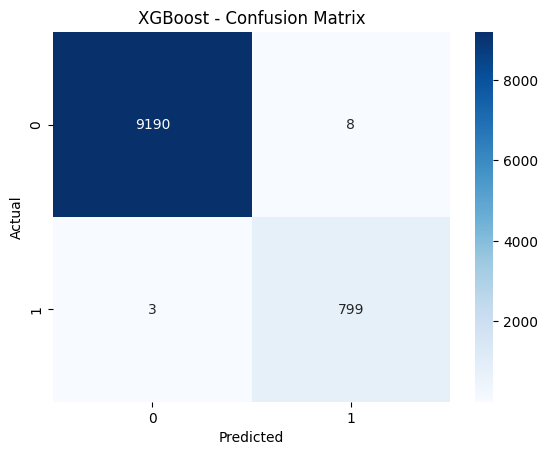

🔢 ROC-AUC Score: 1.0000

🔍 Training Neural Network...
📊 Classification Report for Neural Network
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9198
           1       0.99      0.99      0.99       802

    accuracy                           1.00     10000
   macro avg       1.00      0.99      1.00     10000
weighted avg       1.00      1.00      1.00     10000

🧮 Confusion Matrix for Neural Network


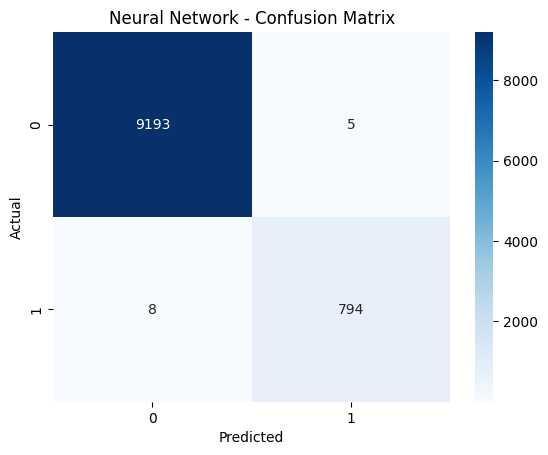

🔢 ROC-AUC Score: 1.0000


In [ ]:
# Step 11: Train, Predict, and Evaluate
results = {}

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    pipeline = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    print(f"📊 Classification Report for {name}")
    print(classification_report(y_test, y_pred))

    print(f"🧮 Confusion Matrix for {name}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"🔢 ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

In [ ]:
# Remove suspect features
suspect_features = [
    'user_product_purchase_count',
    'user_product_interaction_count',
    'user_product_view_count'
]

In [ ]:
# Define new feature set
reduced_features = [f for f in features if f not in suspect_features]

In [ ]:
X_reduced = df[reduced_features]
y = df[target]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Reuse same preprocessing pipeline
categorical_cols_reduced = [col for col in categorical_cols if col in reduced_features]
numerical_cols_reduced = [col for col in reduced_features if col not in categorical_cols_reduced]

In [ ]:
preprocessor_reduced = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols_reduced),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_reduced)
])

In [ ]:
# Choose one model for quick ablation test (e.g., Random Forest)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor_reduced),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [ ]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [ ]:
# Print evaluation
print("📊 Classification Report (Reduced Features - No Behavior Counts)")
print(classification_report(y_test, y_pred))
print(f"🔢 ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

📊 Classification Report (Reduced Features - No Behavior Counts)
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      9198
           1       0.21      0.02      0.04       802

    accuracy                           0.92     10000
   macro avg       0.57      0.51      0.50     10000
weighted avg       0.86      0.92      0.88     10000

🔢 ROC-AUC Score: 0.6473
